In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import seaborn as sns

from importlib.machinery import SourceFileLoader
plotting = SourceFileLoader("plotting", "../../plotting.py").load_module()

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


# Import Data

In [7]:
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')

In [2]:
hourly_mean = xr.open_dataset('../data/monthly_dirunal_cycle.nc')

In [3]:
hourly_mean

<xarray.Dataset>
Dimensions:   (month: 12, hour: 24, nlat: 384, nlon: 320)
Coordinates:
    ULONG     (nlat, nlon) float64 ...
    ULAT      (nlat, nlon) float64 ...
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
  * hour      (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    totChl    (month, hour, nlat, nlon) float32 ...
    daylight  (month, hour, nlat, nlon) float32 ...

In [13]:
local_time_offset = hourly_mean.TLONG/15
hourly_mean['local_time'] = local_time_offset + hourly_mean.hour
hourly_mean['local_time'] = xr.where(hourly_mean.local_time>24, hourly_mean.local_time - 24, hourly_mean.local_time)
hourly_mean = hourly_mean.set_coords('local_time')


In [11]:
hourly_mean['biomes'] = biomes.MeanBiomes
hourly_mean = hourly_mean.set_coords('biomes')

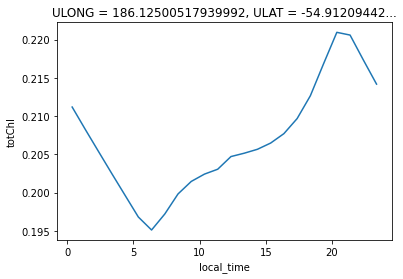

In [14]:
hourly_mean.totChl.isel(nlat=45,nlon=200,month=1).sortby('local_time').plot(x = 'local_time')

# Local time of Min and Max Histograms

## Seasonal

In [322]:
time_min_DJF= (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.min(dim='hour'), drop = True).where(hourly_mean.month.isin([12,1,2]), drop = True).local_time)
time_min_DJF_df = time_min_DJF.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_min_DJF_df['biomes'] = time_min_DJF_df['biomes'].astype(int)

time_min_JJA = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.min(dim='hour'), drop = True).where(hourly_mean.month.isin([6,7,8]), drop = True).local_time)
time_min_JJA_df = time_min_JJA.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_min_JJA_df['biomes'] = time_min_JJA_df['biomes'].astype(int)

In [ ]:
time_max_DJF= (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.max(dim='hour'), drop = True).where(hourly_mean.month.isin([12,1,2]), drop = True).local_time)
time_max_DJF_df = time_max_DJF.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_max_DJF_df['biomes'] = time_max_DJF_df['biomes'].astype(int)

time_max_JJA = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.max(dim='hour'), drop = True).where(hourly_mean.month.isin([6,7,8]), drop = True).local_time)
time_max_JJA_df = time_max_JJA.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_max_JJA_df['biomes'] = time_max_JJA_df['biomes'].astype(int)

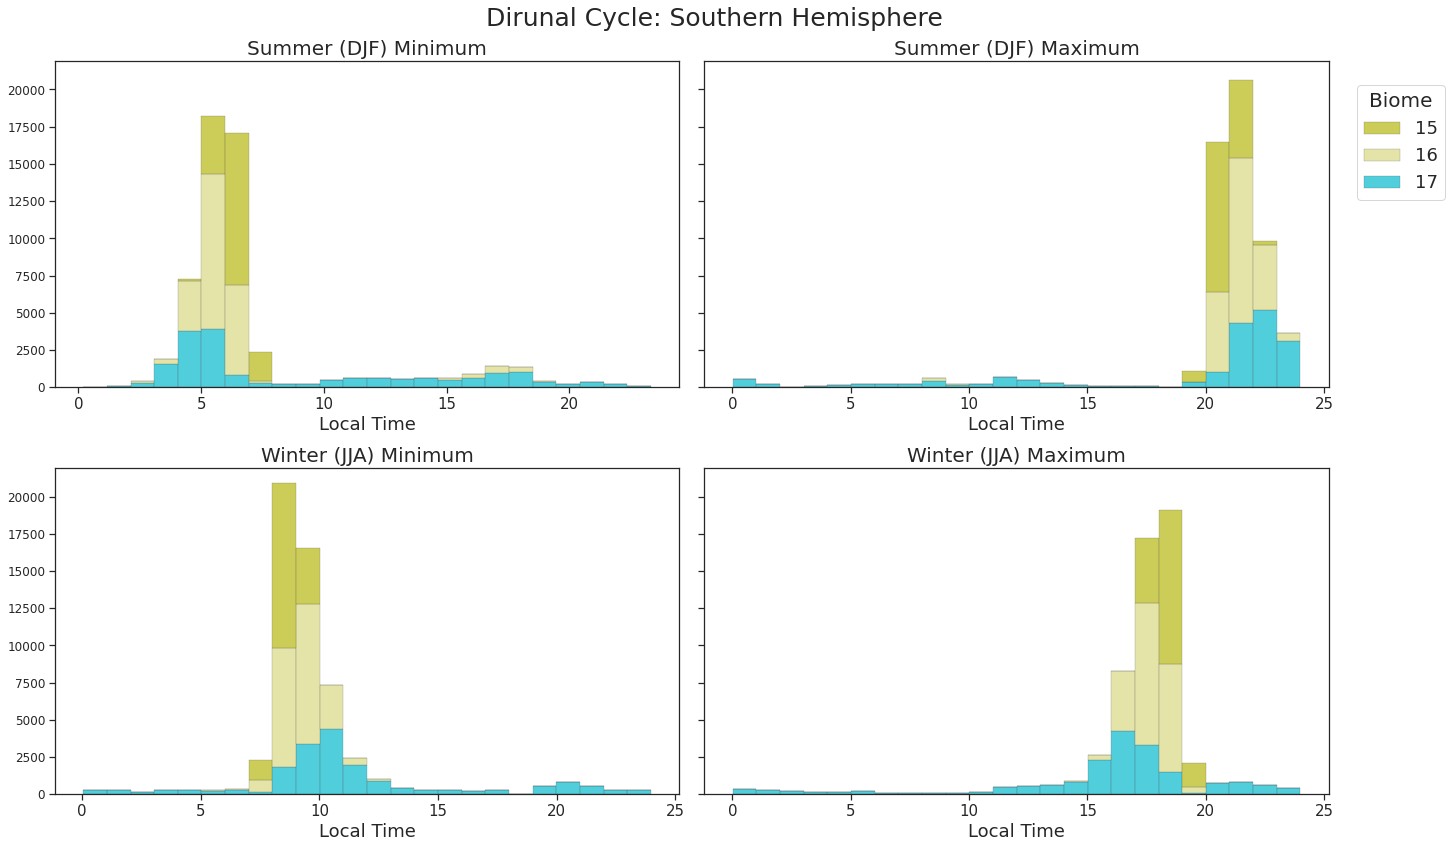

In [392]:
sns.set_theme(style="ticks")
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 12), sharey = True)
axs = axs.flatten()
fig.suptitle('Dirunal Cycle: Southern Hemisphere', fontsize = 25)

ax1 = sns.histplot(
    time_min_DJF_df[time_min_DJF_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[0], legend = False)
ax1.set_title('Summer (DJF) Minimum', fontsize = 20)

ax2 = sns.histplot(
    time_max_DJF_df[time_max_DJF_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[1], legend = True)
ax2.set_title('Summer (DJF) Maximum', fontsize = 20)
sns.move_legend(ax2, "right", bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), ncol=1, fontsize = 18, title = 'Biome', title_fontsize=20)

ax3 = sns.histplot(
    time_min_JJA_df[time_min_JJA_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[2], legend = False)
ax3.set_title('Winter (JJA) Minimum', fontsize = 20)

ax4 = sns.histplot(
    time_max_JJA_df[time_max_JJA_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[3], legend = False)
ax4.set_title('Winter (JJA) Maximum', fontsize = 20)


for ax in axs.flat:
    ax.set_ylabel('')
    ax.set_xlabel('Local Time', fontdict = {'fontsize':18}) 
    ax.tick_params(axis='x',labelsize=15)
    ax.tick_params(axis='y',labelsize=12)

plt.tight_layout()
plt.savefig('../plots/chl_min_max_southern_hem.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

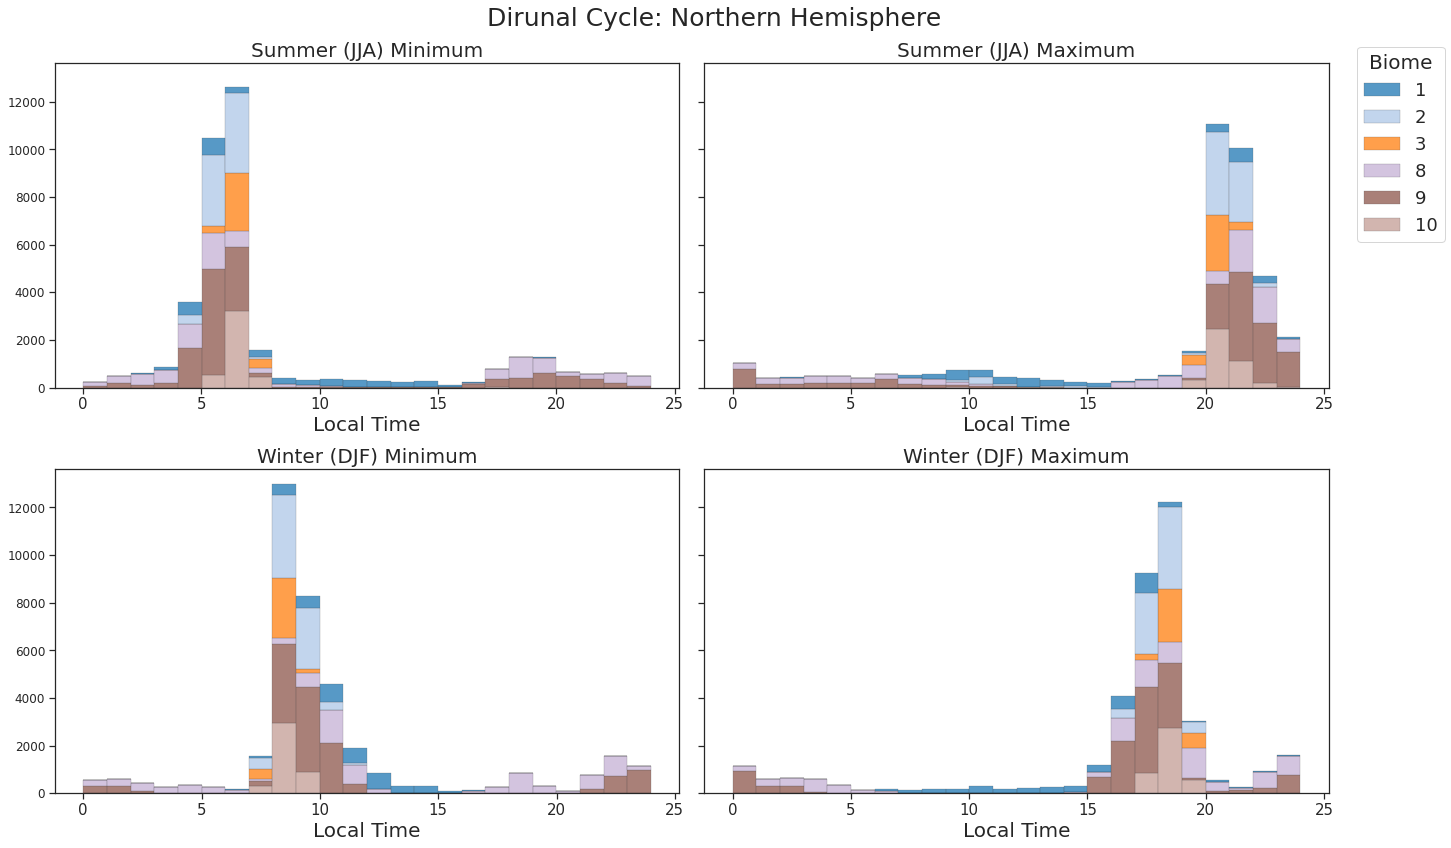

In [393]:
sns.set_theme(style="ticks")
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 12), sharey = True)
axs = axs.flatten()
fig.suptitle('Dirunal Cycle: Northern Hemisphere', fontsize = 25)

ax1 = sns.histplot(
    time_min_JJA_df[time_min_JJA_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[0], legend = False)
ax1.set_title('Summer (JJA) Minimum', fontsize = 20)

ax2 = sns.histplot(
    time_max_JJA_df[time_max_JJA_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[1], legend = True)
ax2.set_title('Summer (JJA) Maximum', fontsize = 20)
sns.move_legend(ax2, "right", bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), ncol=1, fontsize = 18, title = 'Biome', title_fontsize=20)

ax3 = sns.histplot(
    time_min_DJF_df[time_min_DJF_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[2], 
    legend = False)
ax3.set_title('Winter (DJF) Minimum', fontsize = 20)

ax4 = sns.histplot(
    time_max_DJF_df[time_max_DJF_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[3], 
    legend = False)
ax4.set_title('Winter (DJF) Maximum', fontsize = 20)

for ax in axs.flat:
    ax.set_ylabel('')
    ax.set_xlabel('Local Time', fontdict = {'fontsize':20}) 
    ax.tick_params(axis='x',labelsize=15)
    ax.tick_params(axis='y',labelsize=12)

plt.tight_layout()
plt.savefig('../plots/chl_min_max_northern_hem.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

## All Data

In [205]:
time_min = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.min(dim='hour'), drop = True).local_time)
time_min_df = time_min.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_min_df['biomes'] = time_min_df['biomes'].astype(int)

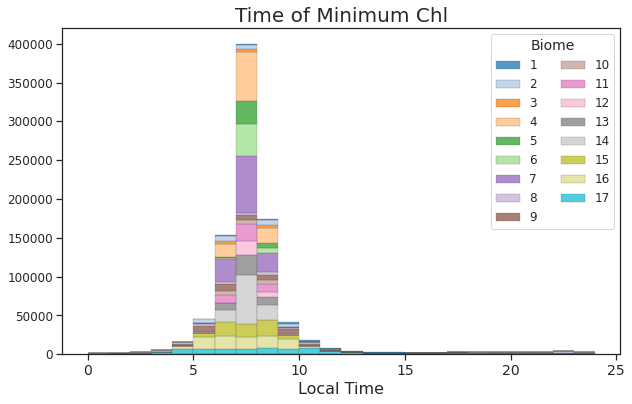

In [396]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.histplot(
    time_min_df,
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2)

sns.move_legend(ax, "upper right", ncol=2, fontsize = 12, title = 'Biome', title_fontsize=14)

plt.xlabel('Local Time', fontsize=16)
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 14)
plt.title('Time of Minimum Chl', fontsize = 20);
plt.savefig('../plots/chl_min_local_time.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [122]:
time_max = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.max(dim='hour'), drop = True).local_time)
time_max_df = time_max.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_max_df['biomes'] = time_max_df['biomes'].astype(int)

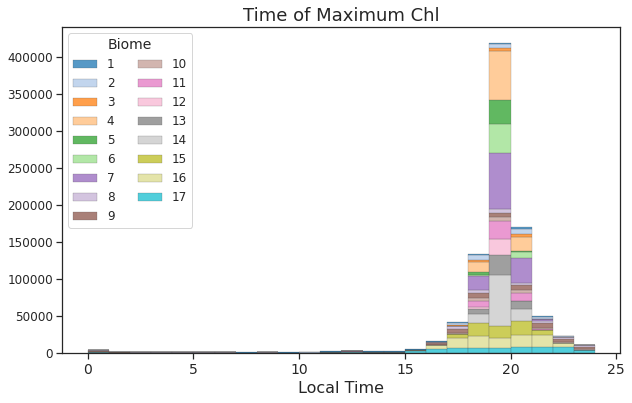

In [395]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.histplot(
    time_max_df,
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    legend = True)

sns.move_legend(ax, "upper left", ncol=2, fontsize = 12, title = 'Biome', title_fontsize=14)

plt.xlabel('Local Time', fontsize=16)
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 14)
plt.title('Time of Maximum Chl', fontsize = 18);
plt.savefig('../plots/chl_max_local_time.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

# Calculate the anomaly at 1:30pm

In [17]:
month_list = []

for m in range(1,13):
    month = hourly_mean.sel(month=m, drop = True)
    loc_time_1pm_all = month.totChl.mean(dim='hour')
    loc_time_1pm_all = xr.where(loc_time_1pm_all, np.nan, np.nan)
    
    for h in range(0,24):
        loc_time_1pm = month.where((month.local_time>=13)&(month.local_time<14)).isel(hour=h).totChl
        loc_time_1pm_all = xr.where(~loc_time_1pm.isnull(), loc_time_1pm, loc_time_1pm_all)
    
    loc_time_1pm_all['month'] = m
    month_list.append(loc_time_1pm_all)

mean_1pm = xr.concat(month_list, dim='month').compute()

In [25]:
monthly_mean = hourly_mean.mean(dim='hour')

In [46]:
anom_1pm = 100*(mean_1pm - monthly_mean)/monthly_mean

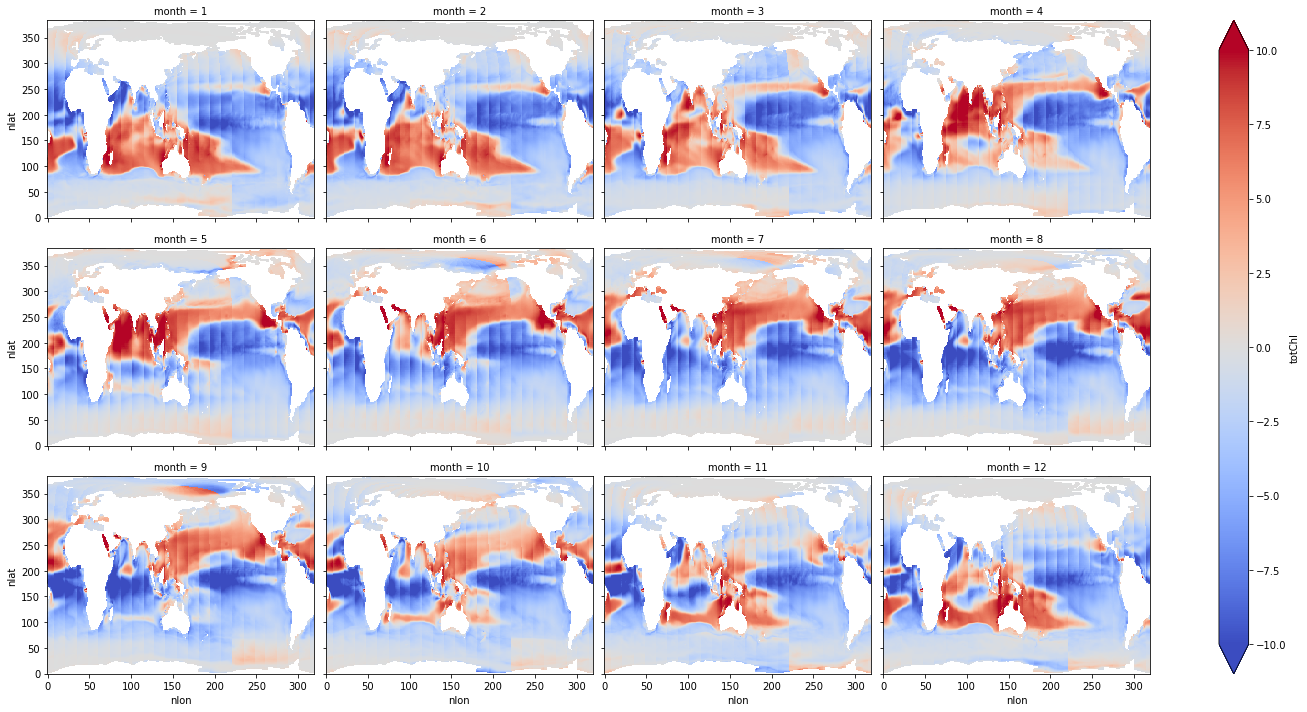

In [48]:
anom_1pm.totChl.plot(col = 'month', col_wrap = 4, vmax = 10, figsize=(20,10), cmap = 'coolwarm')

In [40]:
anom_1pm_year = 100*(mean_1pm.mean(dim='month') - monthly_mean.mean(dim='month'))/ monthly_mean.mean(dim='month')

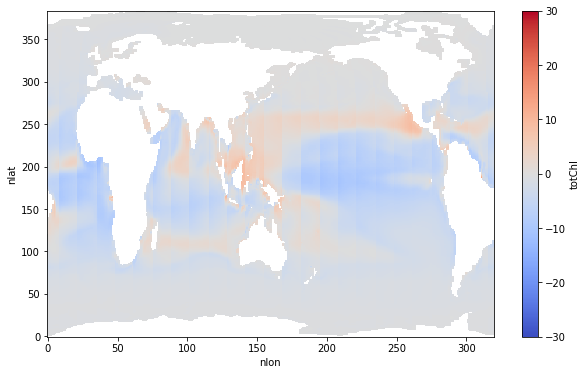

In [49]:
anom_1pm_year.totChl.plot(vmax = 30, cmap = 'coolwarm', figsize = (10,6))

This plot explains most of the differences in the low latitude baseline swath - no swath climatology plots. But what about the large differences at high latitudes? Does it have to do with the number of times that we view the grid cell?

In [50]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nhour1.'

# Pare down the list to just the variables we want to study
varlist = ['totChl_sat_nocld_wgt',
           'totChl_isccp_wgt','totChl_modis_wgt',
           'totChl_sat_nocld_wgt_swath',
           'totChl_modis_wgt_swath','cloudfrac_wgt']

years = range(20,50) 
months = range(1,13)
files = []

for year in years: 
    for month in months:  
        files.append(base+'00{0}-{1}-01-03600.nc'.format(year, str(month).zfill(2)))

wgt_data = xr.open_mfdataset(files, concat_dim="time", parallel = True, chunks = {'time':120},
                              data_vars='minimal', compat='override', 
                              coords='minimal')

wgt_data = wgt_data[varlist]

In [51]:
def wgt_time_mean(da, wgt):
    # da is already multiplied by wgt in pop
    # mean = (da*wgt).sum(dim='time')/wgt.sum(dim='time')
    mean = da.sum(dim='time')/wgt.sum(dim='time')
    return mean 

In [54]:
modis_swath_wgt_mean = wgt_data.totChl_modis_wgt_swath.mean(dim='time').compute()
modis_wgt_mean = wgt_data.totChl_modis_wgt.mean(dim='time').compute()
baseline_swath_wgt_mean = wgt_data.totChl_sat_nocld_wgt_swath.mean(dim='time').compute()
baseline_wgt_mean = wgt_data.totChl_sat_nocld_wgt.mean(dim='time').compute()

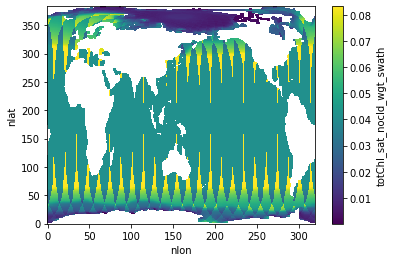

In [56]:
baseline_swath_wgt_mean.plot()

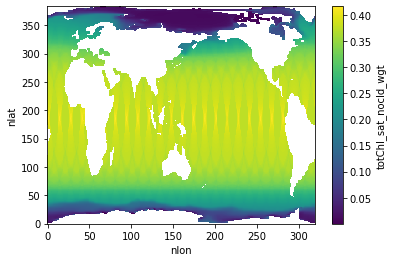

In [60]:
baseline_wgt_mean.plot()

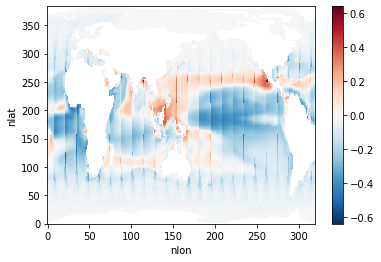

In [88]:
(anom_1pm_year.totChl*baseline_swath_wgt_mean)/.plot()